##  <center>Assignment-2 

**Question-1**

Given:
1. class priors probablities: p(L = 0) = 0.65 and p(L = 1) = 0.35
2. Mean vectors:
    1. $$ \mu_{01} = \begin{bmatrix} 3 \\ 0 \end{bmatrix}$$ <br> 
    2. $$ \mu_{02} = \begin{bmatrix} 0 \\ 3 \end{bmatrix}$$ <br> 
    3. $$ \mu_{1} = \begin{bmatrix}  2 \\ 2 \end{bmatrix}$$ <br> 
3. Covariance Matrices:
    1. $$ \Sigma_{01} = \begin{bmatrix} 2 & 0 \\ 0 & 1 \end{bmatrix}$$ <br> 
    2. $$ \Sigma_{02} = \begin{bmatrix} 1 & 0 \\ 0 & 2 \end{bmatrix}$$ <br> 
    3. $$ \Sigma_{1} = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$$ <br> 
    
4. Parameters of the class conditonal Guassian PDF's:
    1. $$ a_{1} = 0.5 $$
    2. $$ a_{2} = 0.5 $$

**PART-1**

I am implementing this using classification rule:

$${p(x |L=1) \over p(x |(L=0)} > \gamma$$ 

Solution:
ERM CLassifier: with 2 Gaussian Mixture model class conditionals we can derive the above equation to:

$$ \implies {p(x |L=1) \over p(x |(L=0)} = \frac {\sum_{i=1}^ {\mu_{1}} \alpha_{1i} g(x_{i}\mu_{1i}\Sigma_{1i})}{\sum_{i=1}^ {\mu_{0}} \alpha_{0i} g(x_{i}\mu_{0i}\Sigma_{0i}))}$$
$$ \implies {p(x |L=1) \over p(x |(L=0)} = \frac {g(x|m1,C1)}{g(x|m0,C0)} $$

where g(x|m,C) is a multi variate gaussian probablity density function with mean vector m and covariance matrix C.
$$ \implies {p(x |L=1) \over p(x |(L=0)} = \frac {g(x|m1,C1)}{g(x|m0,C0)}  > \gamma$$
$$ \implies {p(x |L=1) \over p(x |(L=0)} = \frac {g(x|m1,C1)}{g(x|m0,C0)}  > \gamma = \frac {p(x|L=0)}{p(x|L=1)} * \frac {\delta_{01}-\delta_{00}}{\delta_{10}-\delta_{11}}$$

$$ \gamma = \frac {p(L=0)}{p(L=1)} * \frac {1 - 0}{1 - 0}$$
$$ \implies \gamma = \frac {0.65}{0.35} $$
$$ \implies \gamma = 1.8572 $$
$$ \implies {p(x |L=1) \over p(x |(L=0)} > \gamma $$
$$ \implies {p(x |L=1) \over p(x |(L=0)} > 1.8572 $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import random
import pandas as pd
from sklearn.mixture import GaussianMixture
import scipy.optimize as spo

In [2]:
priors = [0.65, 0.35]
weights = [.5, .5]
class0_mean = [[3,0],[0,3]]
class0_cov = [[[2,0],[0,1]],[[1,0],[0,2]]]
class1_mean = [2,2]
class1_cov = [[1,0],[0,1]]

In [3]:
def generateData(numSamples):
    # Generate Samples
    labels = []
    samples = []
    for n in range(0, numSamples):
        val = random.random()
        if val < priors[0]:
            labels.append(0)
            if val < priors[0] / 2:
                samples.append(np.random.multivariate_normal(class0_mean[0], class0_cov[0]))
            else:
                samples.append(np.random.multivariate_normal(class0_mean[1], class0_cov[1]))
        else:
            labels.append(1)
            samples.append(np.random.multivariate_normal(class1_mean, class1_cov))

    return samples,labels

In [4]:
#Generating samples and validation set with labes:
D20_train_data, D20_train_labels = generateData(20)
D200_train_data, D200_train_labels = generateData(200)
D2000_train_data, D2000_train_labels = generateData(2000)
D10k_validate_data, D10k_validate_labels = generateData(10000)

Validation set plot:

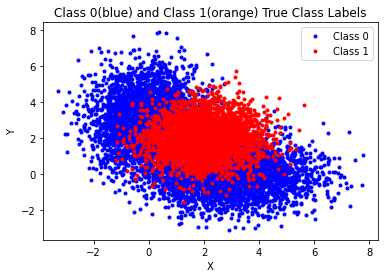

In [5]:
#Plotting validation set:
samp0_10k = [x for (i, x) in enumerate(D10k_validate_data) if D10k_validate_labels[i] == 0]
samp1_10k = [x for (i, x) in enumerate(D10k_validate_data) if D10k_validate_labels[i] == 1]
plt.plot([x[0] for x in samp0_10k], [x[1] for x in samp0_10k], '.', color='blue', label='Class 0')
plt.plot([x[0] for x in samp1_10k], [x[1] for x in samp1_10k], '.', color='red', label='Class 1')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Class 0(blue) and Class 1(orange) True Class Labels')
plt.legend()

In [6]:
#Question 1 Part 1:
discrim = []

for s in D10k_validate_data:
    disc = multivariate_normal.pdf(s, class1_mean, class1_cov) / (0.5 * multivariate_normal.pdf(s, class0_mean[0], class0_cov[0]) + 0.5 * multivariate_normal.pdf(s, class0_mean[1], class0_cov[1]))
    discrim.append(disc)

labelDiscrims10k = pd.DataFrame([D10k_validate_labels, discrim])
#Taking Transpose
labelDiscrims10k = labelDiscrims10k.transpose()
labelDiscrims10k.columns = ['labels', 'discrims']
# Create Gamma thresholds for ROC curve
sortedDisc = sorted(discrim)
gammaVals = [0]
for i, d in enumerate(sortedDisc[0:-1]):
    gammaVals.append((sortedDisc[i]+sortedDisc[i+1])/2.0)

gammaVals.append(sortedDisc[-1] + 1)    # Add a gamma threshold greater than all descriminants
gammas = sorted(gammaVals)

In [7]:
# Generating False and true positive rates
class0Count = len(samp0_10k)
class1Count = len(samp1_10k)
falsePosRate = []
truePosRate = []
perError = []

numGammas = len(gammas)
for ind in range(numGammas):
    trueNegCount = labelDiscrims10k[(labelDiscrims10k['labels'] == 0) & (labelDiscrims10k['discrims'] < gammas[ind])].shape[0]
    falseNegCount = labelDiscrims10k[(labelDiscrims10k['labels'] == 1) & (labelDiscrims10k['discrims'] < gammas[ind])].shape[0]
    falsePosCount = labelDiscrims10k[(labelDiscrims10k['labels'] == 0) & (labelDiscrims10k['discrims'] > gammas[ind])].shape[0]
    truePosCount = labelDiscrims10k[(labelDiscrims10k['labels'] == 1) & (labelDiscrims10k['discrims'] > gammas[ind])].shape[0]
    falsePosRate.append(falsePosCount/class0Count)
    truePosRate.append(truePosCount/class1Count)
    perError.append((falsePosCount + falseNegCount)/10000.0)

Implementing the classifier rule, below are the theoretical and practical values obtained

In [8]:
# Minimum error for gamma
minError = min(perError)
indMinError = perError.index(minError)
print("Gamma (minimum error): " + str(gammas[indMinError]))
print("Minimum probability of error: " + str(minError))

Gamma (minimum error): 1.852603054869423
Minimum probability of error: 0.168


In [9]:
# find theoretical false positive rate, true positive rate, and error
theoDisc = priors[0]/priors[1]
theoTrueNegCount = labelDiscrims10k[(labelDiscrims10k['labels'] == 0) & (labelDiscrims10k['discrims'] < theoDisc)].shape[0]
theoFalseNegCount = labelDiscrims10k[(labelDiscrims10k['labels'] == 1) & (labelDiscrims10k['discrims'] < theoDisc)].shape[0]
theoFalsePosCount = labelDiscrims10k[(labelDiscrims10k['labels'] == 0) & (labelDiscrims10k['discrims'] > theoDisc)].shape[0]
theoTruePosCount = labelDiscrims10k[(labelDiscrims10k['labels'] == 1) & (labelDiscrims10k['discrims'] > theoDisc)].shape[0]
theoFalsePosRate = theoFalsePosCount/class0Count
theoTruePosRate = theoTruePosCount/class1Count
theoError = (theoFalsePosCount + theoFalseNegCount)/10000.0
print("Theoretical optimal gamma is: " + str(theoDisc))
print("Theoretical minimum probability of error is: " + str(theoError))
print("Experimental Minimum error: " +str(truePosRate[indMinError]))

Theoretical optimal gamma is: 1.8571428571428574
Theoretical minimum probability of error is: 0.1682
Experimental Minimum error: 0.7476442873969376


Plotting ROC Curve:

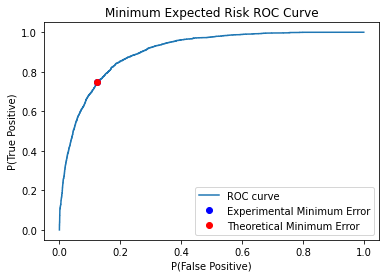

In [10]:
# Plot ROC curve
plt.plot(falsePosRate, truePosRate, label='ROC curve')
plt.plot(falsePosRate[indMinError], truePosRate[indMinError], 'bo', label='Experimental Minimum Error')
plt.plot(theoFalsePosRate, theoTruePosRate, 'ro', label='Theoretical Minimum Error')
plt.ylabel('P(True Positive)')
plt.xlabel('P(False Positive)')
plt.title('Minimum Expected Risk ROC Curve')
plt.legend()
plt.show()

**PART-2(A)**

In [11]:
def logisticFunctionClassificationLikelihood(modelParam, trainData, trainLablels, fit):
    if fit == 'linear':
        z = [np.r_[1, samp] for samp in trainData]
    elif fit == 'quadratic':
        z = [np.r_[1, samp[0], samp[1], samp[0] ** 2, samp[0] * samp[1], samp[1] ** 2] for samp in trainData]
    else:
        print('Unknown fit type for logistic classification')
        exit(-1)
        return
  
    logVals = [1.0/(1 + np.exp(np.matmul(modelParam, z[samp]))) for samp in range(len(trainData))]

    correctLiklihood = [(1-logVals[i]) if trainLablels[i] == 0 else logVals[i] for i in range(len(trainData))]

    return -1 * np.mean(np.log(correctLiklihood))

In [12]:
def optimizeLogisticClassification(trainData, trainLabels, initParams, fit):
    optimizeResult = spo.minimize(fun=logisticFunctionClassificationLikelihood, x0=initParams,
                                  args=(trainData, trainLabels, fit), method='Nelder-Mead')

    if not optimizeResult.success:
        print(optimizeResult.message)
        exit(-1)
    return optimizeResult.x

In [13]:
def plotLogClassPerformance(params, fit, info=''):
    #Checking which classification to use:
    if fit == 'linear':
        likelihoods = [params[0] + params[1] * D10k_validate_data[i][0] +
                       params[2] * D10k_validate_data[i][1] for i in range(10000)]
    elif fit == 'quadratic':
        likelihoods = [params[0] + params[1] * D10k_validate_data[i][0] +
                       params[2] * D10k_validate_data[i][1] +
                       params[3] * (D10k_validate_data[i][0] ** 2) +
                       params[4] * D10k_validate_data[i][0] * D10k_validate_data[i][1] +
                       params[5] * (D10k_validate_data[i][1] ** 2) for i in range(10000)]
    else:
        print('Unknown Fit Type')
        exit(-1)
        return

    decisions = [int(i < 0.5) for i in likelihoods]
    numErrors = 0
    for i in range(10000):
        if decisions[i] != D10k_validate_labels[i]:
            numErrors += 1
    errorProb = numErrors/10000.0
    print('Probability of error ' + info +': ' + str(errorProb))

    # Plot Data As Classified Correct or Incorrect
    class0Correct = [s for (i, s) in enumerate(D10k_validate_data) if D10k_validate_labels[i] == 0 and
                     decisions[i] == 0]
    class0Incorrect = [s for (i, s) in enumerate(D10k_validate_data) if D10k_validate_labels[i] == 0 and
                       decisions[i] == 1]
    class1Correct = [s for (i, s) in enumerate(D10k_validate_data) if D10k_validate_labels[i] == 1 and
                     decisions[i] == 1]
    class1Incorrect = [s for (i, s) in enumerate(D10k_validate_data) if D10k_validate_labels[i] == 1 and
                       decisions[i] == 0]

    plt.plot([x[0] for x in class0Correct], [x[1] for x in class0Correct], '^', color='blue',
             label='Class 0 Correct')
    plt.plot([x[0] for x in class0Incorrect], [x[1] for x in class0Incorrect], '^', color='red',
             label='Class 0 Incorrect')
    plt.plot([x[0] for x in class1Correct], [x[1] for x in class1Correct], 'o', color='blue',
             label='Class 1 Correct')
    plt.plot([x[0] for x in class1Incorrect], [x[1] for x in class1Incorrect], 'o', color='red',
             label='Class 1 Incorrect')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Logistic ' + fit + ' Classification ' + info)
    plt.legend()
    plt.show()

[ 3.95535192 -0.92142485 -0.49470215]
Probability of error 20 Train Samples: 0.3652


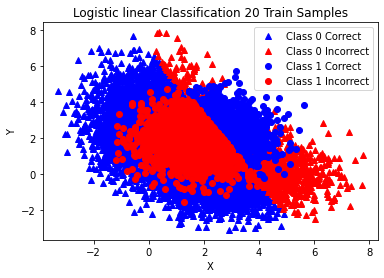

[ 2.1751559  -0.34147402 -0.36143825]
Probability of error 200 Train Samples: 0.3423


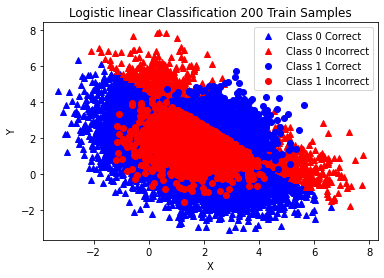

[ 2.13960527 -0.41742692 -0.41249888]
Probability of error 2k Train Samples: 0.3665


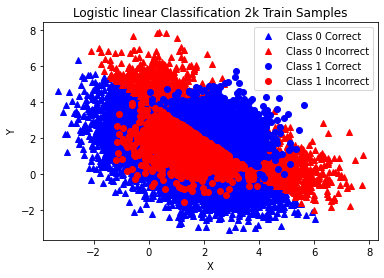

In [14]:
modelParamLin = np.array([0, 0, 0])
modelParamLin = optimizeLogisticClassification(D20_train_data, D20_train_labels, modelParamLin, 'linear')
print(modelParamLin)
plotLogClassPerformance(modelParamLin, 'linear', '20 Train Samples')
modelParamLin = optimizeLogisticClassification(D200_train_data, D200_train_labels, modelParamLin, 'linear')
print(modelParamLin)
plotLogClassPerformance(modelParamLin, 'linear', '200 Train Samples')
modelParamLin = optimizeLogisticClassification(D2000_train_data, D2000_train_labels, modelParamLin, 'linear')
print(modelParamLin)
plotLogClassPerformance(modelParamLin, 'linear', '2k Train Samples')

**PART-2(B)**

Logistic quadratic function based approximations:

[ 1.40063253  0.32520737 -0.45221919  0.31737685 -1.52981461  0.60643085]
Probability of error 20 Train Samples: 0.1785


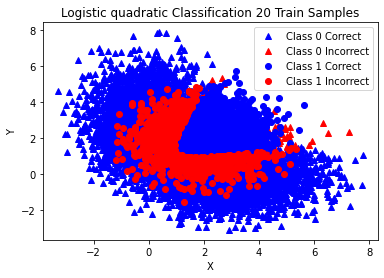

[ 3.18767884 -2.87962999 -1.69620094  0.86943924 -0.62093841  0.65928381]
Probability of error 200 Train Samples: 0.1855


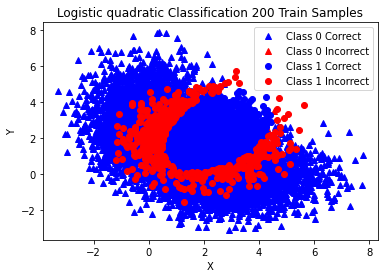

[ 1.83965362 -1.1694015  -0.99674278  0.43044655 -0.60598199  0.41352083]
Probability of error 2k Train Samples: 0.184


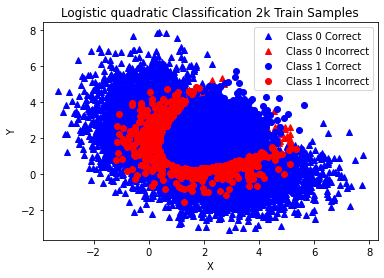

In [15]:
# Using logistic quadratic classification
modelParamQuad = np.array([0, 0, 0, 0, 0, 0])
modelParamQuad = optimizeLogisticClassification(D20_train_data, D20_train_labels, modelParamQuad, 'quadratic')
print(modelParamQuad)
plotLogClassPerformance(modelParamQuad, 'quadratic', '20 Train Samples')
modelParamQuad = optimizeLogisticClassification(D200_train_data, D200_train_labels, modelParamQuad, 'quadratic')
print(modelParamQuad)
plotLogClassPerformance(modelParamQuad, 'quadratic', '200 Train Samples')
modelParamQuad = optimizeLogisticClassification(D2000_train_data, D2000_train_labels, modelParamQuad, 'quadratic')
print(modelParamQuad)
plotLogClassPerformance(modelParamQuad, 'quadratic', '2k Train Samples')

**Conclusions**

1. Logistic Linear:
    1. Probability of error for 20 train samples    - 0.5471
    2. Probability of error for 200 train samples   - 0.3675
    3. Probability of error for 2000 train samples  - 0.3619
2. Logistic quadratic:
    1. Probability of error for 20 train samples    - 0.1785 
    2. Probability of error for 200 train samples   - 0.1855
    3. Probability of error for 2000 train samples  - 0.1840
    
Based on the above probability of errors we can conclude that logistic linear model is a bad fit for the given data and logistic quadratic is a good fit.

Comparing with part-1:
1. Theoretical optimal gamma is: 1.8571428571428574
2. Theoretical minimum probability of error is: 0.1733
3. Experimental Minimum error: 0.7759593679458239

Logistic quadratic is having slight deviation when compared to probability of minimum error with theoretical minimum probability of error and has much difference than logistic linear.

**Question-2** <br>
<br>
Maximum Likelihood(ML) and Maximum-A-Posteriori(MAP) Estimators

Given: <br>
A scalar-real y and two-dimensional real vector x are related to each other y = c(x, w ) + v where c(., w ) is a cubic polynomial in x with coefficients w , and $\epsilon$ is a random Gaussian scalar with mean zero and $\sigma^{2}$ variance $(\epsilon\sim N(0,\sigma^{2}))$

Let<br>
$w=\left[ w_{0},w_{1},w_{2},w_{3},w_{4},w_{5},w_{6} \right]$<br>
$\phi(x_{n})=\left[ 1,x_{1},x_{2},x_{1}^{2},x_{2}^{2},x_{1}^{3},x_{2}^{3} \right]$<br>
Let Dataset $D=(x_{1},y_{1}),(x_{2},y_{2})...(x_{N},y_{N})$

Implementing Maximum Likelihood Estimate(MLE) for Gaussian distribution:
    $argmax_{w}\prod_{n=1}^{N}p(t|\phi(x_{n}),w,\beta)=argmax_{w}\prod_{n=1}^{N}\frac{1}{\sigma\sqrt{2\pi}}exp (-\frac{1}{2}(\frac{t_{n}-w^{T}\phi(x_{n})}{\sigma})^{2})$
where 
$\beta=\frac{1}{\sigma^{2}}$

<br><br>

Taking natural log of the function:
    $argmax_{w}\prod_{n=1}^{N}p(t|\phi(x_{n}),w,\beta)=\frac{N}{2}ln\beta-\frac{N}{2}ln2\pi-\beta E_{D}(w)$

where 
$\beta=\frac{1}{\sigma^{2}}$
<br><br>
$E_{d}(w)=\frac{1}{2}\sum_{n=1}^{N}(t_{n}-w^{T}\phi (x_{n}))^{2}$ is squared error
<br><br>
Set the gradient to zero and solving for the $w$ vector to calculate the maximum probability:
<br>
$\hat{w}_{ML}=0=(\phi^{T}\phi)^{-1}\phi^{T}\hat{t}$<br><br>
Maximum Likelihood Estimate (MLE):
$\implies{w}_{ML}=(\phi^{T}\phi)^{-1}\phi^{T}\hat{t}$<br>

Deriving MAP estimate for a Gaussian Distribution: <br>

Gaussian prior distribution over the weight vector w is defined with the below forumla:

$$ P(w) = Nor(w | 0, \lambda^{-1}I) = \frac{1}{(2\pi)^{D/2}}exp(-\frac{\lambda}{2}w^Tw) $$ <br>

Log posterior probability: <br>
$$ log(P(w | D)) = log \frac{P(w)P(D|w)}{P(D)} $$ <br>
$$\implies log(P(w | D)) = log(P(w)) + log(P(D | w)) - log (P(D)) $$<br>

Maximum-A-Posteriori Estimate:

$$\hat{w}_{MAP} = arg max_{w} log(P(w | D)) $$<br>
$$\implies \hat{w}_{MAP} = arg max_{w} log(P(w))+log(P(D | w))-logP(D) $$<br>
$$\implies \hat{w}_{MAP} = arg max_{w} log(P(w))+log(P(D | w)) $$<br>
$$\implies \hat{w}_{MAP} = arg max_{w}(-\frac{D}{2} log(2\pi) - \frac{\lambda}{2}w^T w + \Sigma_{n=1}^{N} (-\frac{1}{2}log(2\pi\sigma^2) - \frac{(t_{n}-w^T \phi(x_{n}))^2}{2\sigma^2} )) $$ <br>
where $$\Sigma_{n=1}^{N} (-\frac{1}{2}log(2\pi\sigma^2) - \frac{(t_{n}-w^T \phi(x_{n}))^2}{2\sigma^2}$$ is log-Likelihood

Set gradient to zero, we get the below expression:<br>

$$\hat{w}_{MAP}= argmax_{w}-\frac{\lambda}{2}w_{T}w-\beta E_{D}(w) $$
where 
$$\beta=\frac{1}{\sigma^{2}}$$
$$E_{d}(w)=\frac{1}{2}\sum_{n=1}^{N}(t_{n}-w^{T}\phi (x_{n}))^{2}$$ is squared error
<br><br>
$$\implies \hat{w}_{MAP} = (\lambda I+\phi^{T}\phi)^{-1}\phi^{T} \hat{t}$$
Maximum-A-Posteriori Estimate (MAP): $$\implies \hat{w}_{MAP} = (\lambda I+\phi^{T}\phi)^{-1}\phi^{T} \hat{t}$$

In [17]:
import matplotlib.pyplot as plt

import numpy as np

plt.rcParams["figure.figsize"] = (10,10)

def hw2q2():
    Ntrain = 100
    data = generateData(Ntrain)
    plot3(data[:, 0], data[:, 1], data[:, 2], name="Training")
    xTrain = data[:, 0:2]
    yTrain = data[:, 2]

    Ntrain = 1000
    data = generateData(Ntrain)
    plot3(data[:, 0], data[:, 1], data[:, 2], name="Validation")
    xValidate = data[:, 0:2]
    yValidate = data[:, 2]

    return xTrain, yTrain, xValidate, yValidate


def generateData(N):
    gmmParameters = {}
    gmmParameters['priors'] = [.3, .4, .3]  # priors should be a row vector
    gmmParameters['meanVectors'] = np.array([[-10, 0, 10], [0, 0, 0], [10, 0, -10]])
    gmmParameters['covMatrices'] = np.zeros((3, 3, 3))
    gmmParameters['covMatrices'][:, :, 0] = np.array([[1, 0, -3], [0, 1, 0], [-3, 0, 15]])
    gmmParameters['covMatrices'][:, :, 1] = np.array([[8, 0, 0], [0, .5, 0], [0, 0, .5]])
    gmmParameters['covMatrices'][:, :, 2] = np.array([[1, 0, -3], [0, 1, 0], [-3, 0, 15]])
    X = generateDataFromGMM(N, gmmParameters)
    return X


def generateDataFromGMM(N, gmmParameters):
    #    Generates N vector samples from the specified mixture of Gaussians
    #    Returns samples and their component labels
    #    Data dimensionality is determined by the size of mu/Sigma parameters
    priors = gmmParameters['priors']  # priors should be a row vector
    meanVectors = gmmParameters['meanVectors']
    covMatrices = gmmParameters['covMatrices']
    n = meanVectors.shape[0]  # Data dimensionality
    C = len(priors)  # Number of components
    X = np.zeros((n, N))
    labels = np.zeros((1, N))
    # Decide randomly which samples will come from each component
    u = np.random.random((1, N))
    thresholds = np.zeros((1, C + 1))
    thresholds[:, 0:C] = np.cumsum(priors)
    thresholds[:, C] = 1
    for l in range(C):
        indl = np.where(u <= float(thresholds[:, l]))
        Nl = len(indl[1])
        labels[indl] = (l + 1) * 1
        u[indl] = 1.1
        X[:, indl[1]] = np.transpose(np.random.multivariate_normal(meanVectors[:, l], covMatrices[:, :, l], Nl))

    # NOTE TRANPOSE TO GO TO SHAPE (N, n)
    return X.transpose()

def mle(phi, t):
    # get pseudo-inverse
    tphi = np.transpose(phi)
    results = np.matmul(np.linalg.inv(np.matmul(tphi,phi)),tphi)
    # multiply by y
    results = np.matmul(results, t)
    return results

def mean_squared_error(w, x_test, y_test):
    N = len(y_test)
    x = []
    for i in range(0,N,1):
        row = [1, x_test[0][i], x_test[1][i], x_test[0][i]**2, 
                x_test[1][i]**2, x_test[0][i]**3, x_test[1][i]**3]
        x.append(row)
    total_error = 0
    for n in range(0,N,1):
        error = (y_test[n]-np.dot((w),x[n]))**2
        total_error = total_error + error
    total_error = total_error/N
    return total_error[0,0]

def map(phi, gamma, t):
    # get pseudo-inverse
    tphi = np.transpose(phi)
    results = np.matmul(np.linalg.inv(np.add(gamma*np.identity(phi.shape[1]), np.matmul(tphi,phi))),tphi)
    # multiply by y
    results = np.matmul(results, t)
    return results

def plot3(a, b, c, name="Training", mark="o", col="b"):
    # Adjusts the aspect ratio and enlarges the figure (text does not enlarge)
    fig = plt.figure()

    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(a, b, c, marker=mark, color=col)
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.set_zlabel(r"$y$")
    plt.title("{} Dataset".format(name))
    # To set the axes equal for a 3D plot
    ax.set_box_aspect((np.ptp(a), np.ptp(b), np.ptp(c)))
    plt.show()

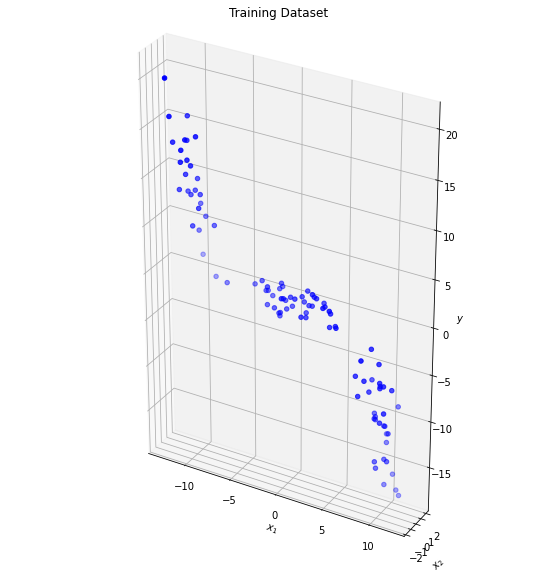

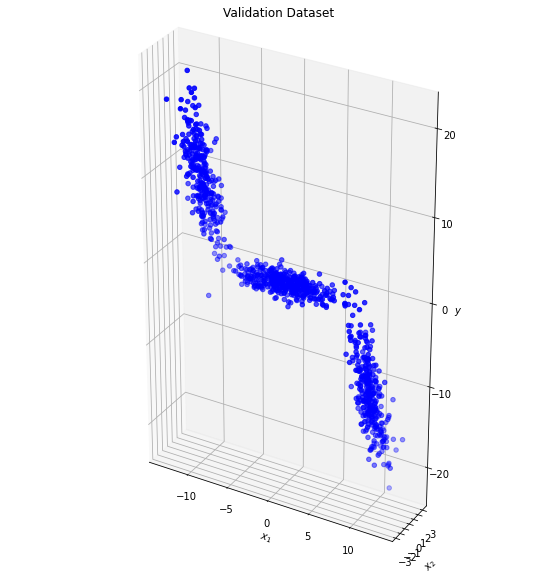

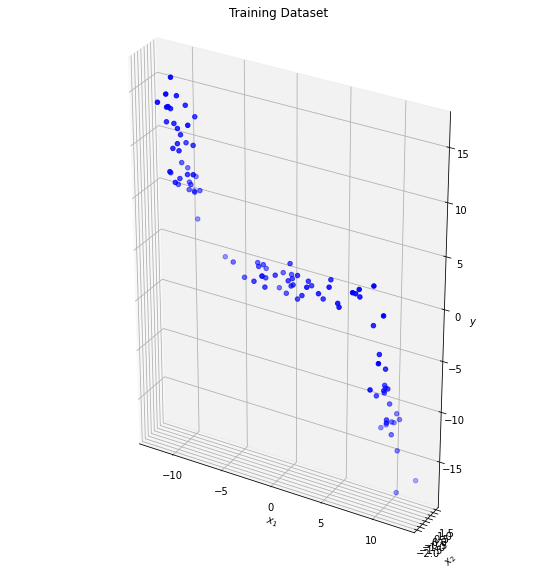

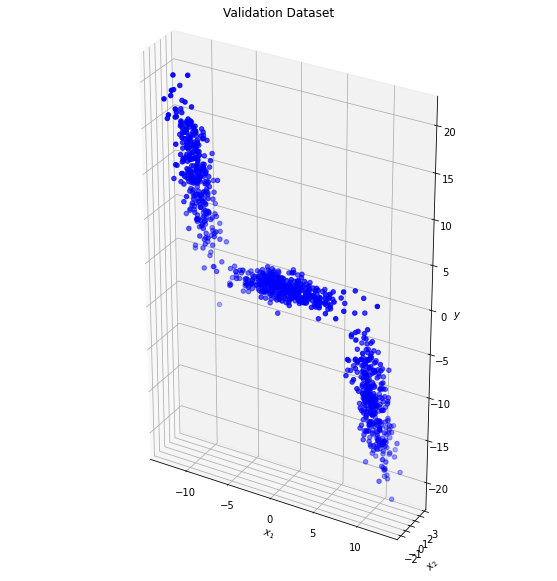

(100, 2)
(1000, 2)
4.724482969632689
0.0001
4.724481376036141
0.001
4.724467034407223
0.01
4.724323691325661
0.1
4.722897534430538
1.0
4.7093195656804685
10.0
4.61595591489373
100.0
4.389731293882889
1000.0
4.2972570156482215
10000.0
4.334886551118686


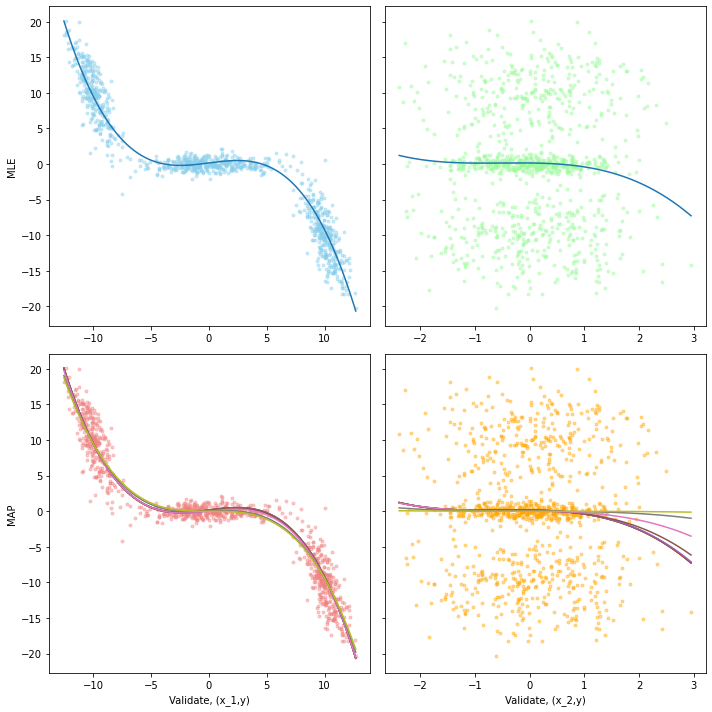

In [22]:
#if __name__=='__main__':
# train has 100 samples, validate has 1000 samples
if __name__ == '__main__':
    hw2q2()
    N = 100
    xTrain, yTrain, xValidate, yValidate = hw2q2()
    #N = 100
    
    print(xTrain.shape)
    print(xValidate.shape)
    phi = []
    xT = xTrain.transpose()
    yT = yTrain.transpose()
    xV = xValidate.transpose()
    yV = yValidate.transpose()
    

    
    fig, axes = plt.subplots(2,2, figsize=(10, 10), sharex=False, sharey=True)
    for i in range(0,100,1):
        row = [1, xT[0][i], xT[1][i], xT[0][i]**2, 
                xT[1][i]**2, xT[0][i]**3, xT[1][i]**3]
        phi.append(row)
    phi = np.matrix(phi)
    
    
    

    # Plot training data
    for i in range(0,1000,1):
        axes[0,0].plot(xV[0][i], yV[i], color='skyblue', marker='.', alpha=0.4)
        axes[0,1].plot(xV[1][i], yV[i], color='palegreen', marker='.', alpha=0.4)
        axes[1,0].plot(xV[0][i], yV[i], color='lightcoral', marker = '.', alpha=0.4)
        axes[1,1].plot(xV[1][i], yV[i], color='orange', marker='.', alpha=0.4)
    min_x_0 = min(xV[0])
    max_x_0 = max(xV[0])
    min_x_1 = min(xV[1])
    max_x_1 = max(xV[1])

    # MLE
    mle_w = mle(phi, yT)
    error = mean_squared_error(mle_w, xV, yV)
    print(error)
    # Add lines to plots
    x_0 = np.linspace(min_x_0, max_x_0, num=1000)
    x_1 = np.linspace(min_x_1, max_x_1, num=1000)
    w = np.transpose(mle_w)[:,0]
    fx = []
    for i in range(len(x_0)):
        x = x_0[i]
        # w: 0,1,3,5
        fx.append(w[0]+w[1]*x+w[3]*x**2+w[5]*x**3)
    fx = np.squeeze(fx)
    axes[0,0].plot(x_0,fx)
    fx = []
    for i in range(len(x_1)):
        x = x_1[i]
        # w: 0,1,3,5
        fx.append(w[0]+w[2]*x+w[4]*x**2+w[6]*x**3)
    fx = np.squeeze(fx)
    axes[0,1].plot(x_1,fx)


    # MAP
    gammas = [i for i in np.logspace(-4,4,9)]
    for gamma in gammas:
        print(gamma)
        map_w = map(phi, gamma, yT)
        error = mean_squared_error(map_w, xV, yV)
        print(error)
        w = np.transpose(map_w)[:,0]
        fx = []
        for i in range(len(x_0)):
            x = x_0[i]
            # w: 0,1,3,5
            fx.append(w[0]+w[1]*x+w[3]*x**2+w[5]*x**3)
        fx = np.squeeze(fx)
        axes[1,0].plot(x_0,fx)
        fx = []
        for i in range(len(x_1)):
            x = x_1[i]
            # w: 0,1,3,5
            fx.append(w[0]+w[2]*x+w[4]*x**2+w[6]*x**3)
        fx = np.squeeze(fx)
        axes[1,1].plot(x_1,fx)
    axes[0,0].set_ylabel('MLE')
    axes[1,0].set_ylabel('MAP')
    axes[1,0].set_xlabel('Validate, (x_1,y)')
    axes[1,1].set_xlabel('Validate, (x_2,y)')
    plt.tight_layout()
    plt.show()

Generated Datasets:

Outputs of the MLE trained model and Mean squared errors for varied $\gamma$ values in the case of MAP trained model:

Outputs of the Validation data scattered:

Obtained and assessed the estimators using the train and validate data sets produced by the given python scripts.
1. The Mean Squared Error for the MLE trained model is: 4.724482969632689
2. Both the worst performing MLE trained model and the worst performing MAP trained model were equally awful. This is true since the MLE estimate requires a uniform prior which is comparable to gamma of 0.
3. As gamma approaches 0, the performance of the MAP estimate resembles that of the MLE estimate.
4. Model trained using MAP performed better when the gamma was higher this is due to an increase in the regularization to the prior.